## Student Name: Francisco Leite Meireles da Fonseca

## Student ID: 23281227

## Task 1: Data Preparation Pipeline
Open a new Jupyter notebook and name it etivity2.ipynb. In this notebook, create a data preparation pipeline that applies the same transformations that you applied as part of e-tivity 1. It is OK to leave some of the transformations outside the pipeline but aim at including as many transformations as you can within the pipeline. Follow the notebook Tutorial 2 - Clustering and Manifold Learning.ipynb as an example.

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import DBSCAN


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

### Load the data

In [142]:
# Load the data
df = pd.read_csv('bank.csv')
print("Number of examples and number of attributes:", df.shape)

Number of examples and number of attributes: (2000, 17)


### Exploratory Data Analysis and Data Preparation

In [143]:
df.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [144]:
df.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes

In [145]:
df.describe()

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

In [146]:
df.isnull().sum()

age            12
job            10
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact       191
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

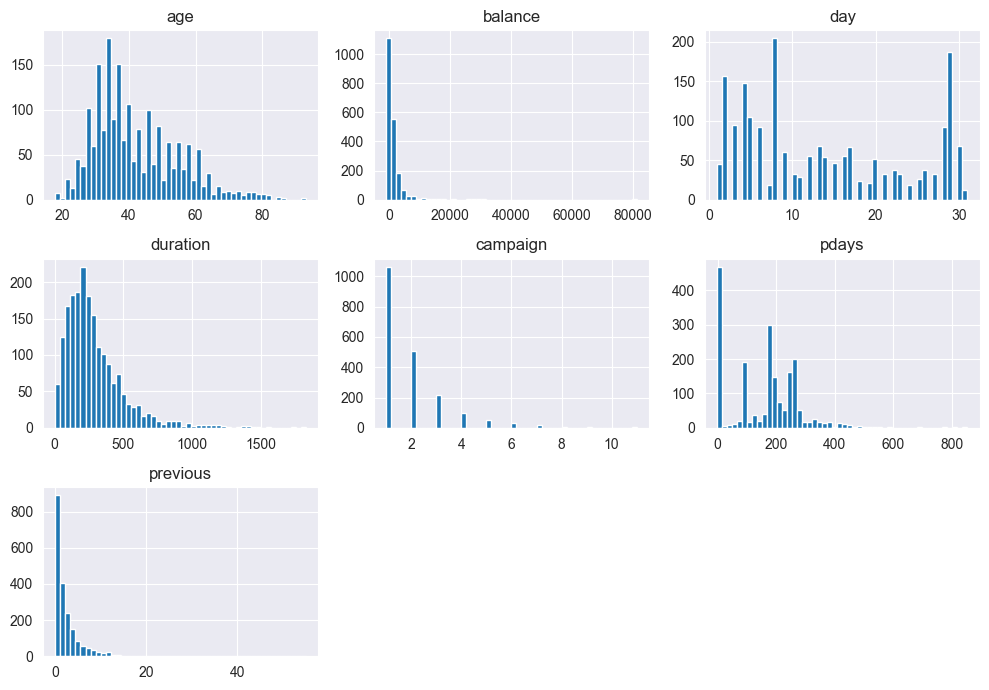

In [147]:
# Plotting histograms of the numerical attributes
df.hist(bins=50, figsize=(10, 7))
plt.tight_layout()

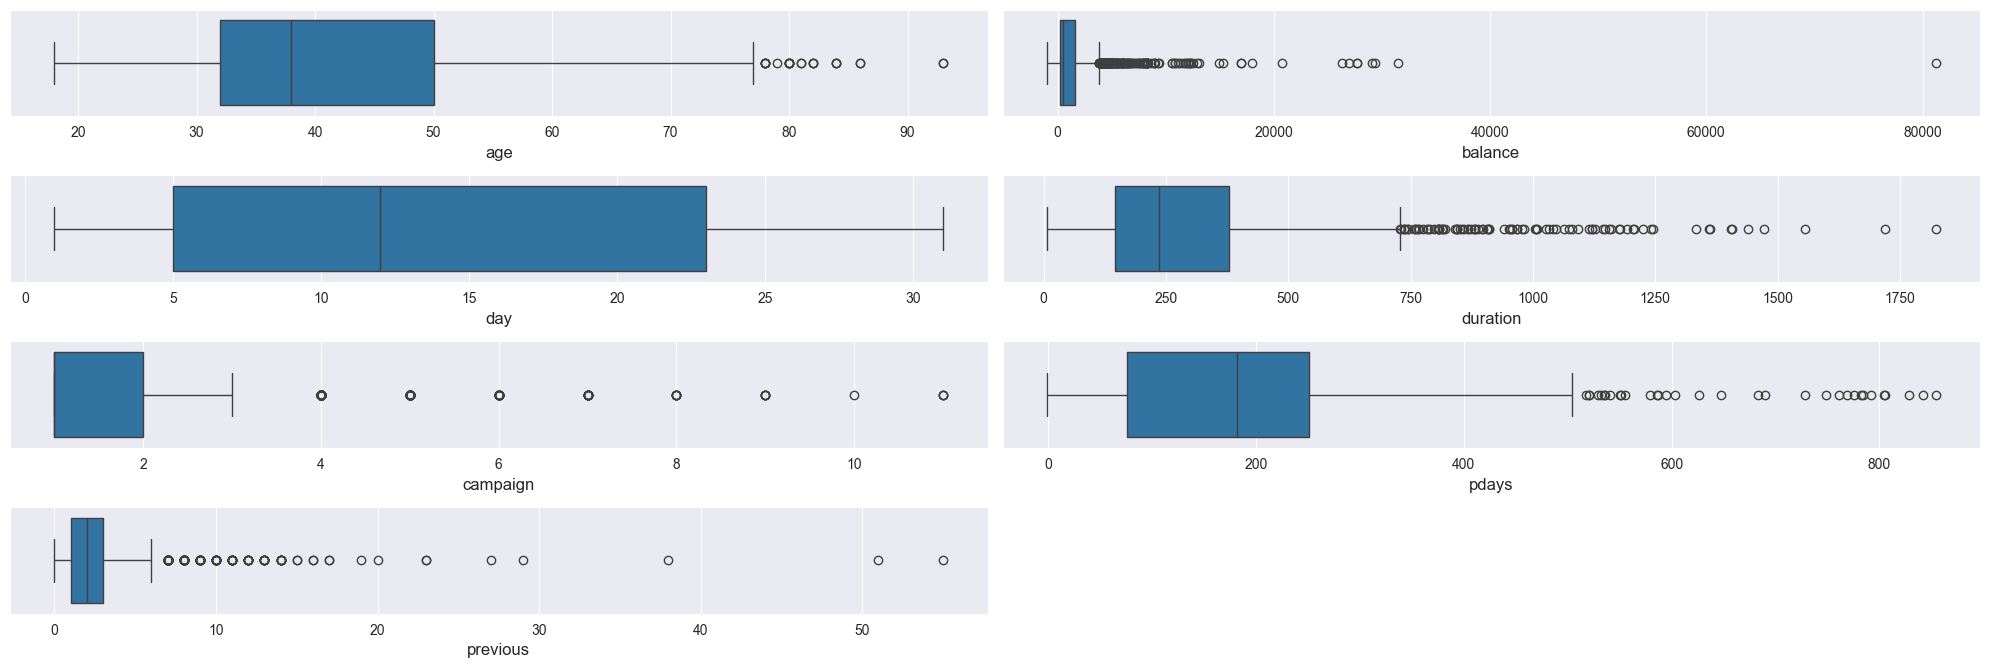

In [148]:
fig, axes = plt.subplots(5, 2, figsize=(20, 8))  # Adjusting the size for better visibility

# transforms a 2D array into a 1D array to make it easier to iterate over the subplots
axes = axes.flatten()

# Creates boxplots for each numeric column in the dataframe
for i, col in enumerate(df.select_dtypes(include=[np.number]).columns):
    sns.boxplot(data=df, x=col, orient='h', ax=axes[i])
    axes[i].set_xlabel(col, fontsize=12)

# removes the extra subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

### Data Preparation Pipeline

In [149]:
from sklearn.base import BaseEstimator, TransformerMixin


class OutlierTreater(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor

    def fit(self, X, y=None):
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_bound_ = Q1 - self.factor * IQR
        self.upper_bound_ = Q3 + self.factor * IQR
        return self

    def transform(self, X, y=None):
        X = np.clip(X, self.lower_bound_, self.upper_bound_)
        return X

In [150]:
original_df = df
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

numerical_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('outlier_treater', OutlierTreater(3)),
    ('scaler', RobustScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [151]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)

## Task 2: k-Means
In your notebook e-tivity2.ipynb:

Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.
Use the Silhouette Coefficient method to determine the best value of k as well.
Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.
Use MDS and t-SNE for visualising the clusterings. Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).

Best k according to the Silhouette Coefficient: 2


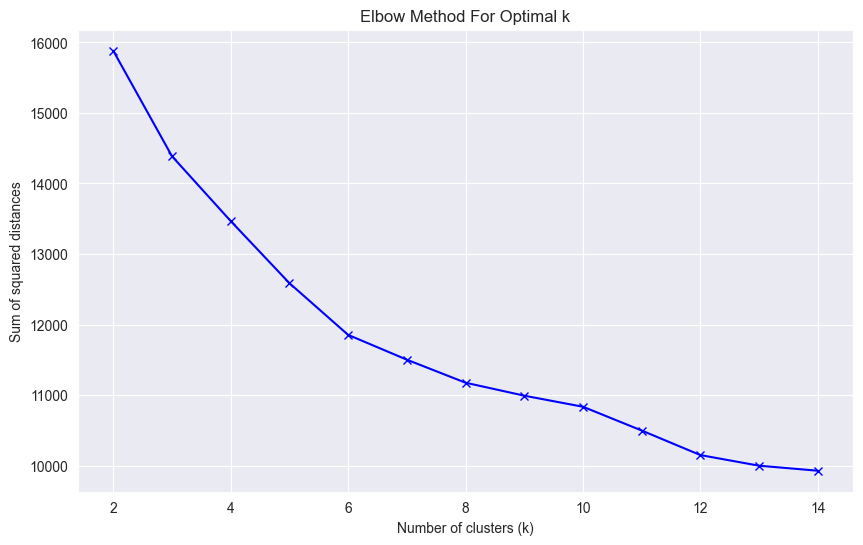

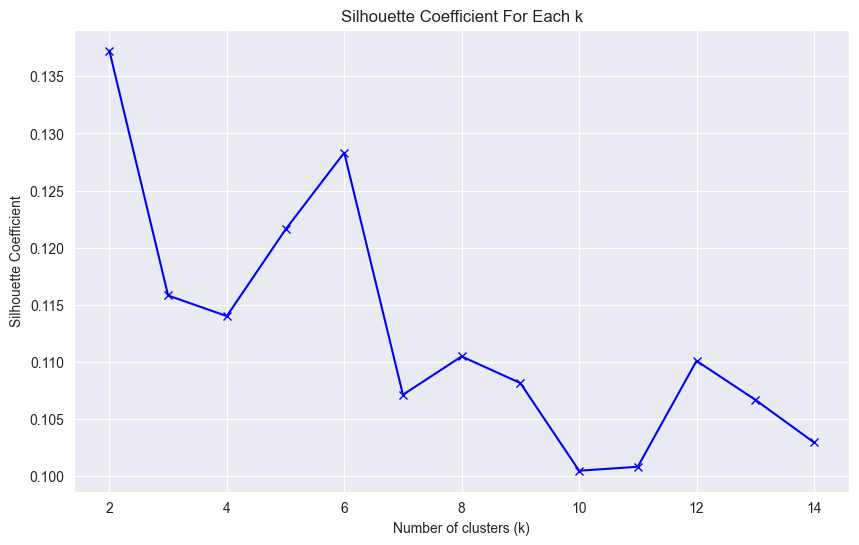

In [152]:
sse = {}
silhouette_coefficients = []
k_values = range(2, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_transformed)
    sse[k] = kmeans.inertia_
    score = silhouette_score(X_train_transformed, kmeans.labels_)
    silhouette_coefficients.append(score)
    
# print best k according to the Silhouette Coefficient
best_k = k_values[np.argmax(silhouette_coefficients)]
print(f'Best k according to the Silhouette Coefficient: {best_k}')

# plot the SSE (Elbow Method)
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# plot the Silhouette Coefficients
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_coefficients, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient For Each k')
plt.show()

In [153]:
# Clustering with the best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_train_transformed)
clusters = kmeans.labels_

# Add the cluster labels to your dataset for further analysis
X_train['cluster'] = clusters

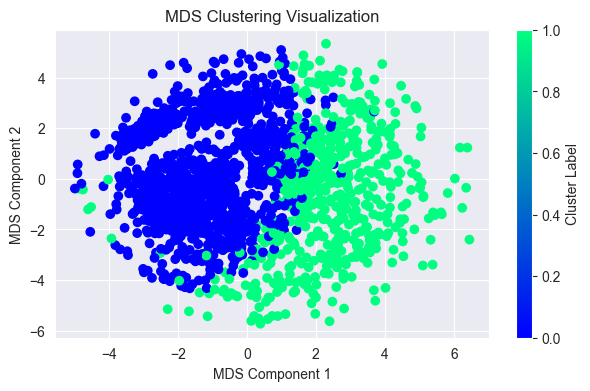

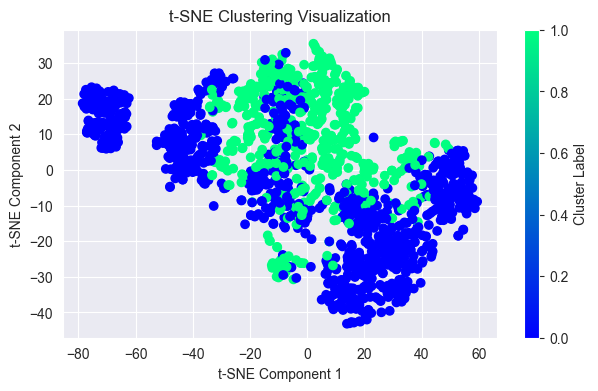

In [154]:
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_train_transformed)

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_transformed)

# Plotting the clusters using MDS
plt.figure(figsize=(7, 4))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=clusters, cmap='winter', marker='o')
plt.title('MDS Clustering Visualization')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Plotting the clusters using t-SNE
plt.figure(figsize=(7, 4))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='winter', marker='o')
plt.title('t-SNE Clustering Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

### Task 3
In your notebook e-tivity2.ipynb:

Apply the DBSCAN clustering algorithm to the prepared bank dataset.
Use MDS and t-SNE for visualising the clustering. Write a short conclusion about the characteristics of the clusters and compare the performance of DBSCAN to k-Means. (max 250 words in a markdown cell).

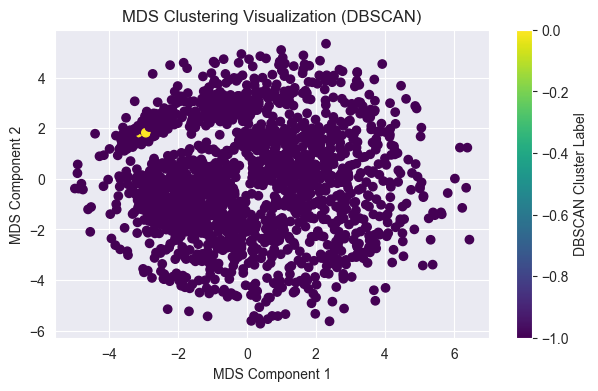

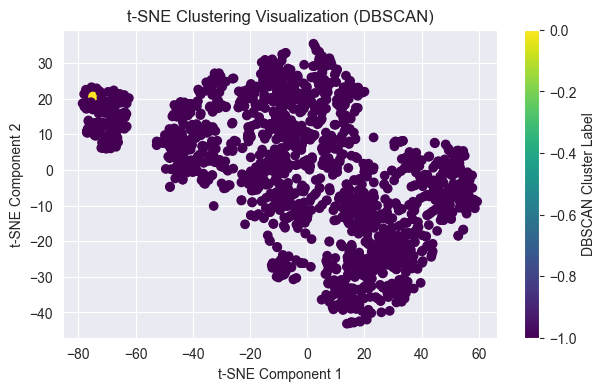

In [155]:
dbscan = DBSCAN(eps=0.8,  min_samples=7)
dbscan.fit(X_train_transformed)
dbscan_clusters = dbscan.labels_


mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_train_transformed)
plt.figure(figsize=(7, 4))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=dbscan_clusters, cmap='viridis', marker='o')
plt.title('MDS Clustering Visualization (DBSCAN)')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.colorbar(label='DBSCAN Cluster Label')
plt.show()

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_transformed)
plt.figure(figsize=(7, 4))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_clusters, cmap='viridis', marker='o')
plt.title('t-SNE Clustering Visualization (DBSCAN)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='DBSCAN Cluster Label')
plt.show()